In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join('/kaggle/input/air-quality-data-set/AirQuality.csv'))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-quality-data-set/AirQuality.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
csv_file = '/kaggle/input/air-quality-data-set/AirQuality.csv'

df = pd.read_csv(csv_file, sep=';')

In [4]:
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)
df=df.dropna()

In [5]:
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

In [6]:
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)
year_series = dt_series.dt.year
month_series = dt_series.dt.month
day_series = dt_series.dt.day
day_name_series = dt_series.dt.day_name()


In [7]:
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series
df = df.sort_values(by='DateTime')

In [8]:
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

In [9]:
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] 
for col in cols_to_correct: 
    df[col] = comma_to_period(df[col])

In [10]:
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]
for col in aq_2004_df.columns[1:-4]:
    median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
    aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

In [11]:
for col in aq_2005_df.columns[1:-4]:
    median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
    aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')
df = pd.concat([aq_2004_df, aq_2005_df])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int32         
 11  Month          9357 non-null   int32         
 12  Day            9357 non-null   int32         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int32(3), object(1)
memory usage: 986.9+ KB

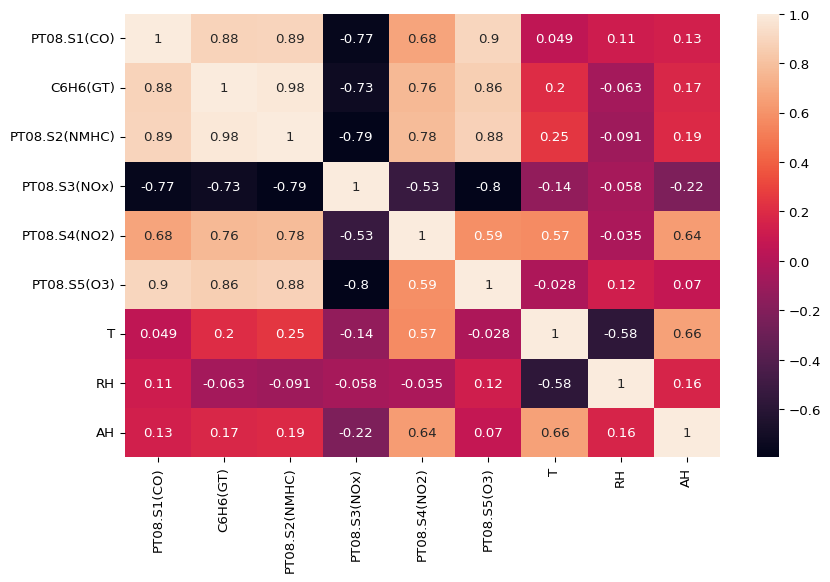

In [12]:
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) 
plt.show()


In [13]:
from sklearn.model_selection import train_test_split

X = df['T']
y = df['RH'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) 


In [14]:
def errors_product():
    prod = (X_train - X_train.mean()) * (y_train - y_train.mean())
    return prod

def squared_errors():
    sq_errors = (X_train - X_train.mean()) ** 2
    return sq_errors

In [15]:
slope = errors_product().sum()/ squared_errors().sum()
intercept = y_train.mean() - slope * X_train.mean()

print(f"Slope: {slope} \nIntercept: {intercept}")

Slope: -1.112053910794772 
Intercept: 69.69110324644876


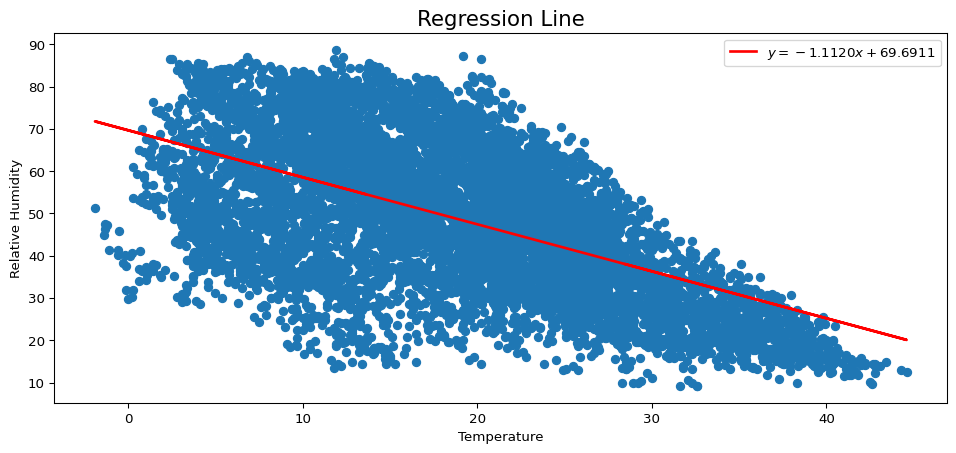

In [16]:
plt.figure(figsize = (12, 5), dpi = 96)
plt.title("Regression Line", fontsize = 16)
plt.scatter(df['T'], df['RH'])
plt.plot(df['T'], slope * df['T'] + intercept, color = 'r', linewidth = 2, label = '$y = -1.1120x + 69.6911$')
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.legend()
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression

X_train_reshaped = X_train.values.reshape(-1, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)


lin_reg = LinearRegression()
lin_reg.fit(X_train_reshaped, y_train_reshaped)

print("Coefficient of $x$ (or slope) ==>", lin_reg.coef_)
print("Intercept ==>", lin_reg.intercept_)

Coefficient of $x$ (or slope) ==> [[-1.11205391]]
Intercept ==> [69.69110325]


In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = lin_reg.predict(X_train_reshaped)
y_test_pred = lin_reg.predict(X_test_reshaped)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")


Train Set
--------------------------------------------------
R-squared: 0.325
Mean Squared Error: 195.281
Root Mean Squared Error: 13.974
Mean Absolute Error: 11.289


Test Set
--------------------------------------------------
R-squared: 0.346
Mean Squared Error: 187.026
Root Mean Squared Error: 13.676
Mean Absolute Error: 11.150
